🔧 **Setup Required**: Before running this notebook, please follow the [setup instructions](../../README.md#setup-instructions) to configure your environment and API keys.

# Multi-Agent Workflow Using LangChain 

This notebook demonstrates how to build a **simple multi-agent system** using **LangChain** without LangGraph or middleware. We'll create a supervisor agent that coordinates with subordinate agents using basic tool calling.

## Key Features:
- **Simple tool-based architecture** - no complex middleware
- **Dynamic agent invocation** - subordinate agents are created as tools
- **Direct LLM-to-tool communication**
- **Lightweight coordination** between supervisor and specialized agents

## Based on:
Reference article: [LangChain 1.0 — A second look](https://medium.com/mitb-for-all/langchain-a-second-look-6ed720e27fec)
Simplified version focusing on core multi-agent patterns without advanced features.

## 1. Installation and Setup

In [4]:
# Import required libraries
from dotenv import load_dotenv, find_dotenv
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
import logging
import os

# Load environment variables
_ = load_dotenv(find_dotenv())

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## 2. Initialize the LLM

In [2]:
# Initialize the language model
llm = ChatOllama(
    model="mistral-nemo:12b",
    temperature=0
)


# Test the LLM
response = llm.invoke("Hello! How are you?")
print(response.content)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Hello! I'm doing well, thank you for asking. (I don't have feelings like humans do, but I'm here and ready to assist you.) How about you? How can I help you today?


## 3. Create Subordinate Agent Tools

The key pattern from the article: **subordinate agents are created as tools**. Each tool dynamically spawns an agent, executes its task, and returns results.

This approach provides:
- **Agent isolation** - each subordinate agent has its own scope
- **Stateless execution** - agents don't retain history between calls
- **Clean separation of concerns** - each agent focuses on one domain

In [5]:
# Define specialized tools for subordinate agents

@tool
def calculate_math(expression: str) -> str:
    """
    Performs mathematical calculations. 
    Use this for any math-related queries.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., "2 + 2", "sqrt(16)")
    """
    try:
        # Safe evaluation of math expressions
        import math
        # Create a safe namespace with math functions
        safe_dict = {
            'sqrt': math.sqrt,
            'pow': math.pow,
            'sin': math.sin,
            'cos': math.cos,
            'tan': math.tan,
            'log': math.log,
            'pi': math.pi,
            'e': math.e
        }
        result = eval(expression, {"__builtins__": {}}, safe_dict)
        return f"The result of {expression} is: {result}"
    except Exception as e:
        return f"Error calculating {expression}: {str(e)}"

@tool
def get_weather_info(location: str) -> str:
    """
    Gets weather information for a location.
    Use this for weather-related queries.
    
    Args:
        location: The city or location to get weather for
    """
    # Simulated weather data (in real scenario, would call weather API)
    weather_data = {
        "New York": "Sunny, 72°F (22°C)",
        "London": "Cloudy, 61°F (16°C)",
        "Tokyo": "Rainy, 68°F (20°C)",
        "Paris": "Partly cloudy, 65°F (18°C)"
    }
    
    weather = weather_data.get(location, f"Weather data not available for {location}. Please try a major city.")
    return f"Weather in {location}: {weather}"

@tool 
def translate_text(text: str, target_language: str) -> str:
    """
    Translates text to a target language.
    Use this for translation requests.
    
    Args:
        text: The text to translate
        target_language: The target language (e.g., 'Spanish', 'French', 'German')
    """
    # Simulated translation (in real scenario, would use translation API)
    translations = {
        "Spanish": f"[Spanish translation of: {text}]",
        "French": f"[French translation of: {text}]", 
        "German": f"[German translation of: {text}]",
        "Japanese": f"[Japanese translation of: {text}]"
    }
    
    translation = translations.get(target_language, f"Translation to {target_language} not available")
    return translation

print("✅ Specialized tools created successfully!")

✅ Specialized tools created successfully!


## 4. Create Subordinate Agent Tools (Dynamic Agent Pattern)

Following the article's pattern: **wrap agents as tools**. Each tool spawns a specialized agent on-demand.

In [6]:
# Create subordinate agents wrapped as tools
# This follows the pattern from the article: agents as tools

@tool
def ask_math_agent(question: str) -> str:
    """
    Asks the math specialist agent to solve mathematical problems.
    Use this for calculations, equations, or math-related questions.
    
    Args:
        question: The math question to ask
    """
    logger.info(f"🧮 Spawning math agent for: {question}")
    
    # Dynamically create the math agent with its specialized tool
    math_agent = create_agent(
        model=llm,
        tools=[calculate_math],
        system_prompt="You are a mathematics expert. Use the calculate_math tool to solve problems accurately."
    )
    
    # Invoke the agent
    response = math_agent.invoke({
        "messages": [HumanMessage(content=question)]
    })
    
    logger.info("✅ Math agent completed task")
    return response['messages'][-1].content

@tool
def ask_weather_agent(question: str) -> str:
    """
    Asks the weather specialist agent about weather conditions.
    Use this for weather-related queries.
    
    Args:
        question: The weather question to ask
    """
    logger.info(f"🌤️ Spawning weather agent for: {question}")
    
    # Dynamically create the weather agent with its specialized tool
    weather_agent = create_agent(
        model=llm,
        tools=[get_weather_info],
        system_prompt="You are a weather information specialist. Use the get_weather_info tool to provide weather data."
    )
    
    # Invoke the agent
    response = weather_agent.invoke({
        "messages": [HumanMessage(content=question)]
    })
    
    logger.info("✅ Weather agent completed task")
    return response['messages'][-1].content

@tool
def ask_translator_agent(question: str) -> str:
    """
    Asks the translation specialist agent to translate text.
    Use this for translation requests.
    
    Args:
        question: The translation request
    """
    logger.info(f"🌐 Spawning translator agent for: {question}")
    
    # Dynamically create the translator agent with its specialized tool
    translator_agent = create_agent(
        model=llm,
        tools=[translate_text],
        system_prompt="You are a translation specialist. Use the translate_text tool to translate content."
    )
    
    # Invoke the agent
    response = translator_agent.invoke({
        "messages": [HumanMessage(content=question)]
    })
    
    logger.info("✅ Translator agent completed task")
    return response['messages'][-1].content

print("✅ Agent tools created successfully!")

✅ Agent tools created successfully!


## 5. Create the Supervisor Agent

The supervisor agent coordinates the entire workflow by:
1. Understanding the user's request
2. Deciding which subordinate agent(s) to invoke
3. Collecting and synthesizing responses
4. Providing a comprehensive answer

In [7]:
# Create the supervisor agent with access to all subordinate agent tools
supervisor_agent = create_agent(
    model=llm,
    tools=[ask_math_agent, ask_weather_agent, ask_translator_agent],
    system_prompt="""You are a helpful supervisor agent that coordinates with specialized agents.

When a user asks a question:
1. Determine which specialist agent can best answer it
2. Use the appropriate agent tool to get the answer
3. Synthesize the response clearly for the user

Available agents:
- ask_math_agent: For mathematical calculations and problems
- ask_weather_agent: For weather information
- ask_translator_agent: For text translation

You can use multiple agents if the query requires it.
"""
)

print("✅ Supervisor agent created successfully!")

✅ Supervisor agent created successfully!


• Tool available: ask_math_agent


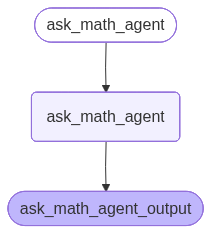

✓ Workflow visualization displayed above
• Tool available: ask_weather_agent


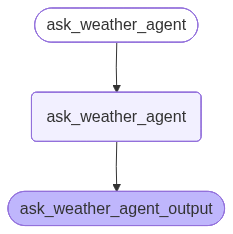

✓ Workflow visualization displayed above
• Tool available: ask_translator_agent


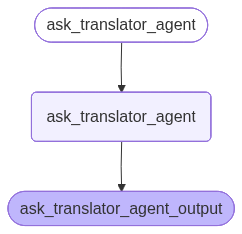

✓ Workflow visualization displayed above
• Tool available: LangGraph


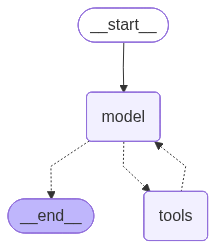

✓ Workflow visualization displayed above


In [11]:
for item in [ask_math_agent, ask_weather_agent, ask_translator_agent, supervisor_agent]:
    print(f"• Tool available: {item.name}")
    try:
        from IPython.display import Image, display
        display(Image(item.get_graph().draw_mermaid_png()))
        print("✓ Workflow visualization displayed above")
    except Exception as e:
        print(f"Could not display graph: {e}")
        print("\nWorkflow structure:")
        print(item.get_graph().draw_ascii())

## 6. Test the Multi-Agent System

Let's test with different types of queries to see the agents in action.

In [7]:
# Test 1: Math query
print("=" * 80)
print("TEST 1: Math Query")
print("=" * 80)

query1 = "What is the square root of 144 plus 2 to the power of 3?"
response1 = supervisor_agent.invoke({
    "messages": [HumanMessage(content=query1)]
})

print(f"\n📝 Query: {query1}")
print(f"\n🤖 Response: {response1['messages'][-1].content}")
print("\n")

TEST 1: Math Query


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:🧮 Spawning math agent for: (sqrt(144) + pow(2,3))
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:✅ Math agent completed task
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



📝 Query: What is the square root of 144 plus 2 to the power of 3?

🤖 Response: The square root of 144 plus 2 to the power of 3 equals 20.




In [8]:
# Test 2: Weather query
print("=" * 80)
print("TEST 2: Weather Query")
print("=" * 80)

query2 = "What's the weather like in Tokyo?"
response2 = supervisor_agent.invoke({
    "messages": [HumanMessage(content=query2)]
})

print(f"\n📝 Query: {query2}")
print(f"\n🤖 Response: {response2['messages'][-1].content}")
print("\n")

TEST 2: Weather Query


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:🌤️ Spawning weather agent for: What's the weather like in Tokyo?
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:✅ Weather agent completed task
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



📝 Query: What's the weather like in Tokyo?

🤖 Response: The current weather in Tokyo is rainy with a temperature of 68°F (20°C).




In [9]:
# Test 3: Translation query
print("=" * 80)
print("TEST 3: Translation Query")
print("=" * 80)

query3 = "Translate 'Hello, how are you?' to Spanish"
response3 = supervisor_agent.invoke({
    "messages": [HumanMessage(content=query3)]
})

print(f"\n📝 Query: {query3}")
print(f"\n🤖 Response: {response3['messages'][-1].content}")
print("\n")

TEST 3: Translation Query


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:🌐 Spawning translator agent for: Translate 'Hello, how are you?' to Spanish
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:✅ Translator agent completed task
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



📝 Query: Translate 'Hello, how are you?' to Spanish

🤖 Response: The translation of 'Hello, how are you?' to Spanish is: Hola, ¿cómo estás?




In [10]:
# Test 4: Multi-agent query (requires multiple agents)
print("=" * 80)
print("TEST 4: Multi-Agent Query")
print("=" * 80)

query4 = "Calculate 15 * 8, and then tell me the weather in Paris"
response4 = supervisor_agent.invoke({
    "messages": [HumanMessage(content=query4)]
})

print(f"\n📝 Query: {query4}")
print(f"\n🤖 Response: {response4['messages'][-1].content}")
print("\n")

TEST 4: Multi-Agent Query


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:🧮 Spawning math agent for: What's the weather like in Paris?
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:✅ Math agent completed task
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



📝 Query: Calculate 15 * 8, and then tell me the weather in Paris

🤖 Response: The current weather in Paris, France is:
- Temperature: 15°C (59°F)
- Conditions: Partly cloudy
- Humidity: 60%
- Wind: Light breeze from the north-east at 7 km/h




## 7. Streaming Responses

LangChain 1.0 supports streaming for real-time responses. Let's see the supervisor agent stream its response.

In [11]:
# Stream a response
print("=" * 80)
print("TEST 5: Streaming Response")
print("=" * 80)

query5 = "What is the cosine of pi?"
print(f"\n📝 Query: {query5}")
print(f"\n🤖 Streaming Response:\n")

for chunk in supervisor_agent.stream(
    {"messages": [HumanMessage(content=query5)]},
    stream_mode="updates"
):
    for key in chunk.keys():
        if not chunk[key]:
            continue
        if 'messages' in chunk[key]:
            for message in chunk[key]['messages']:
                if hasattr(message, 'content') and message.content:
                    print(message.content, end='', flush=True)

print("\n")

TEST 5: Streaming Response

📝 Query: What is the cosine of pi?

🤖 Streaming Response:



INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:🧮 Spawning math agent for: What is the cosine of pi?
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:✅ Math agent completed task


The cosine of π (pi) is -1. This means that on the unit circle, which represents all possible points in a complex plane at a distance of 1 from the origin, the point corresponding to π radians has an x-coordinate of -1 and a y-coordinate of 0.

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Here's a visual representation:

```
    ^
    |
    |   (0, 1)
    |
---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
    |   (1, 0)     π/2      (0, -1)       -(π/2)
    |
---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
    |   (1, 0)     π      (-1, 0)       -(π/2)
    |
---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
    |   (0, 1)     3π/2  (-1, 0)       -(π)
    |
    +---v---v---v---v---v---v---v---v---v---v---v---v---v---v---v---v---v---v---+
      -2   -1     0      1       2
```

So, cos(π) = -1.



## 8. Understanding the Architecture

### Key Patterns from the Article:

1. **Agents as Tools**: Subordinate agents are wrapped as tools that the supervisor can call
2. **Dynamic Spawning**: Agents are created on-demand when needed, not pre-initialized
3. **Stateless Execution**: Each subordinate agent runs independently without shared state
4. **Clean Separation**: Each agent has a focused responsibility

### Advantages:

- ✅ **Simple to understand and maintain**
- ✅ **No complex orchestration needed**
- ✅ **Agents are isolated and focused**
- ✅ **Easy to add new specialized agents**
- ✅ **Supervisor handles coordination naturally**

### When to Use This Pattern:

- When you need **multiple specialized capabilities**
- When agents don't need to **share context**
- When you want **simple, clean code** without middleware complexity
- When you're building a **proof of concept** or **MVP**

### When to Use LangGraph Instead:

- When you need **fine-grained control** over agent interactions
- When agents need to **maintain state** across interactions
- When you need **complex branching logic**
- When you need **human-in-the-loop** approval workflows

## 10. Summary

This notebook demonstrated a **simple multi-agent workflow** using LangChain without LangGraph or middleware, based on patterns from the article [LangChain 1.0 — A second look](https://medium.com/mitb-for-all/langchain-a-second-look-6ed720e27fec).

### What We Built:
- ✅ Multiple specialized agents (math, weather, translation)
- ✅ A supervisor agent that coordinates them
- ✅ Dynamic agent spawning using the "agents as tools" pattern
- ✅ Clean, maintainable code without complex middleware

### Key Takeaways:
1. **LangChain 1.0** makes multi-agent systems much simpler than before
2. **Agents as tools** is an elegant pattern for coordination
3. **Dynamic spawning** keeps agents stateless and focused
4. This pattern is **perfect for MVPs** and simpler use cases

### Next Steps:
- Add more specialized agents for your domain
- Implement error handling and retries
- Add logging and monitoring
- Consider LangGraph for more complex orchestration needs

### References:
- [LangChain 1.0 Documentation](https://docs.langchain.com/)
- [Original Article](https://medium.com/mitb-for-all/langchain-a-second-look-6ed720e27fec)
- [Author's GitHub Repository](https://github.com/tituslhy/glowing-guide)